### Prerequisites

Installing `tflite` as we are converting TFLite model.

In [3]:
!pip install tflite apache-tvm opencv-python

### Install old Xgboost

[Tracking bug](https://discuss.tvm.apache.org/t/running-autoschedule-demo-meeting-error-importerror-cannot-import-name-earlystopexception-from-xgboost-core/12819)

In [4]:
!pip install xgboost==1.5.0

Importing all required modules: tflite, tvm, autotvm, and opencv2

In [5]:
import cv2
import logging
import multiprocessing
import numpy as np
import os
import sys
import tflite
import tvm
import tvm.testing

from matplotlib import pyplot as plt

from tvm import autotvm
from tvm import relay
from tvm import te
from tvm import transform
from tvm.autotvm.tuner import XGBTuner, GATuner, RandomTuner, GridSearchTuner
from tvm.contrib import graph_executor
from tvm.driver import tvmc

Define variable visible to the entire notebook: compilation target.

In [6]:
target = "llvm -mtriple=x86_64-linux-gnu"

### Convert TF Lite model to TVM model and fix layout for tuning

In [7]:
tflite_model_buf = open('selfie_multiclass_256x256.tflite', "rb").read()
tflite_model = tflite.Model.GetRootAsModel(tflite_model_buf, 0)

In [8]:
input_tensor = "input_29"
input_shape = (1, 256, 256, 3)
input_dtype = "float32"

mod, params = relay.frontend.from_tflite(
    tflite_model, shape_dict = {input_tensor: input_shape }, dtype_dict={input_tensor: input_dtype}
)

In [9]:
with tvm.transform.PassContext(opt_level=3):
    mod_nchw = tvm.relay.transform.InferType()(mod)
    mod_nchw = tvm.relay.transform.ConvertLayout({"nn.conv2d": ["NCHW", "OIHW"],
                                                  "image.resize2d": ["NCHW"],
                                                  "nn.conv2d_transpose": ["NCHW", "OIHW"]})(mod_nchw)

In [10]:
# Build the module against to x86 CPU
with transform.PassContext(opt_level=3):
    lib = relay.build(mod_nchw, target, params=params)

### Test the converted model

Test that the model with converted layout can do reasonable inference.
The input image should be **normalised**.

In [11]:
def load_image_for_inference(image_path: str) -> np.ndarray:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    image = image.astype(np.float32)

    image[:, :, 0] = (image[:, :, 0] / 255.0)
    image[:, :, 1] = (image[:, :, 1] / 255.0)
    image[:, :, 2] = (image[:, :, 2] / 255.0)


    image = np.expand_dims(image, axis=0)
    return image

In [12]:
image = load_image_for_inference('example3.jpg')

print('image shape:', image.shape)
print('image min value:', image.min())
print('image max value:', image.max())

image shape: (1, 256, 256, 3)
image min value: 0.0
image max value: 1.0


In [13]:
module = graph_executor.GraphModule(lib["default"](tvm.cpu()))
module.set_input(input_tensor, tvm.nd.array(image))

module.run()

tvm_output = module.get_output(0).numpy()

print('output shape:', tvm_output.shape)

output shape: (1, 256, 256, 6)


In [14]:
CLASSES = {
    0: 'background',
    1: 'hair',
    2: 'body-skin',
    3: 'face-skin',
    4: 'clothes',
    5: 'accessories'
}

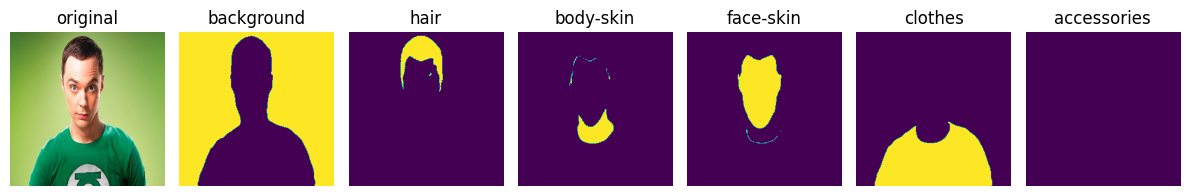

In [15]:
n = len(CLASSES)
fig, ax = plt.subplots(nrows=1, ncols=(n + 1), figsize=(12, 12))

ax[0].set_title('original')
ax[0].imshow(image[0, :, :, :])
ax[0].axis("off")

for i in range(n):
    sample = tvm_output[0, :, :, i]
    sample_label = CLASSES[i]

    ax[i + 1].set_title(sample_label)
    ax[i + 1].imshow(sample > 0.5)
    ax[i + 1].axis("off")

plt.tight_layout()
plt.show()

### Save TVMC model

Let's save our untuned model.

In [16]:
def convert_params_to_numpy(parameters: dict[str: tvm.nd.NDArray]) -> dict[str: np.ndarray]:
    patched_parameters = {}

    for k, v in parameters.items():
        patched_parameters[k] = v.numpy()

    return patched_parameters

In [17]:
def load_tvm_parameters(path: str) -> dict[str: tvm.nd.NDArray]:
    raw_parameters = np.load(path)

    patched_parameters = {}

    for k, v in raw_parameters.items():
        patched_parameters[k] = tvm.nd.array(v)

    return patched_parameters

In [18]:
def add_prefix_to_parameters(parameters: dict,
                             prefix: str) -> dict:
    patched_parameters = {}

    for k, v in parameters.items():
        patched_parameters[f"{prefix}{k}"] = v

    return patched_parameters

In [19]:
def create_tvmc_model(model,
                      parameters,
                      file_name):
    with open(f"{file_name}.txt", "w") as f:
        f.write(repr(mod_nchw))

    return tvmc.load(f"{file_name}.txt", shape_dict={ input_tensor: input_shape, **vparams }, model_format="relay")

In [20]:
vparams = add_prefix_to_parameters(params, prefix='v')

In [21]:
np.save('parameters', convert_params_to_numpy(vparams))

In [22]:
tvmc_model = create_tvmc_model(mod_nchw, vparams, file_name='selfie_multiclass_256x256')

In [23]:
tvmc.compile(tvmc_model, target=target,
             tuning_records='tvmc_compilation.log',
             package_path="selfie_multiclass_not_tuned.tar")

#### Check inference on TVMC model

In [24]:
package = tvmc.TVMCPackage(package_path="selfie_multiclass_not_tuned.tar")

inputs = {input_tensor: image, **vparams }
num_iter = 10
result = tvmc.run(package, device="cpu", inputs=inputs,
                  benchmark=True, number=num_iter)

tvmc_output = result.outputs["output_0"]
print('output shape:', tvmc_output.shape)

2023-12-18 13:24:10.480 INFO load_module /tmp/tmponopbdws/mod.so


output shape: (1, 256, 256, 6)


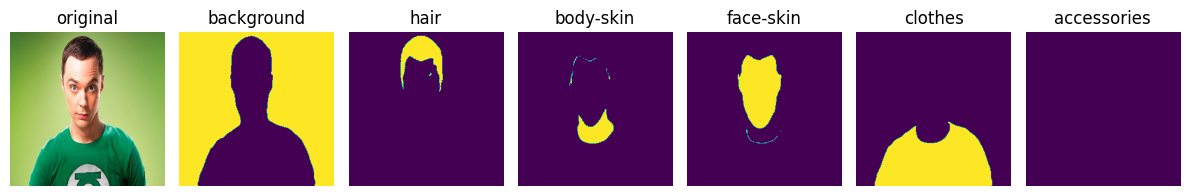

In [25]:
n = len(CLASSES)
fig, ax = plt.subplots(nrows=1, ncols=(n + 1), figsize=(12, 12))

ax[0].set_title('original')
ax[0].imshow(image[0, :, :, :])
ax[0].axis("off")

for i in range(n):
    sample = tvmc_output[0, :, :, i]
    sample_label = CLASSES[i]

    ax[i + 1].set_title(sample_label)
    ax[i + 1].imshow(sample > 0.5)
    ax[i + 1].axis("off")

plt.tight_layout()
plt.show()

### AutoTVM tuning

In [26]:
log_file = "statistics.log"

In [27]:
def evaluate_performance(input_name, lib, data_shape, dtype="float32"):
    # upload parameters to device
    dev = tvm.cpu()
    data_tvm = tvm.nd.array((np.random.uniform(size=data_shape)).astype(dtype))
    module = graph_executor.GraphModule(lib["default"](dev))
    module.set_input(input_name, data_tvm)

    # evaluate
    print("Evaluate inference time cost...")
    print(module.benchmark(dev, number=100, repeat=3))

In [28]:
# extract workloads from relay program
def extract_tasks_autotvm(mod, target, params):
    print("Extract tasks...")
    print(mod)
    tasks = autotvm.task.extract_from_program(
        mod, target=target, params=params
    )
    assert(len(tasks) > 0)
    return tasks

def evaluate_autotvm(input_name, model, data_shape, log_file, target="llvm"):
    # compile kernels in default mode
    print("Evaluation of the network compiled in 'default' mode without auto tune:")
    with tvm.transform.PassContext():
        print("Compile...")
        lib = relay.build(model, target=target, params=params)
        evaluate_performance(input_name, lib, data_shape)

    # compile kernels in kernel tuned only mode
    print("\nEvaluation of the network been tuned on kernel level:")
    with autotvm.apply_history_best(log_file):
        print("Compile...")
        with tvm.transform.PassContext():
            lib = relay.build(model, target=target, params=params)
        evaluate_performance(input_name, lib, data_shape)

In [29]:
# Set number of threads used for tuning based on the number of
# physical CPU cores on your machine.
num_threads = multiprocessing.cpu_count()
print("Num threads: ", num_threads)
os.environ["TVM_NUM_THREADS"] = str(num_threads)

Num threads:  2


In [30]:
tuning_option = {
    "log_filename": log_file,
    "tuner": "xgb",
    "early_stopping": False,
    "n_trial": 333,
    "measure_option": autotvm.measure_option(
        builder=autotvm.LocalBuilder(),
        runner=autotvm.LocalRunner(
            number=1, repeat=10, min_repeat_ms=0, enable_cpu_cache_flush=True
        ),
    ),
}

In [31]:
def run_tuning_autotvm(
    tasks, measure_option, n_trial=0, tuner="gridsearch", early_stopping=None, log_filename="tuning.log"
):
    for i, task in enumerate(tasks):
        prefix = "[Task %2d/%2d] " % (i + 1, len(tasks))

        if tuner == "xgb" or tuner == "xgb-rank":
            tuner_obj = XGBTuner(task, loss_type="rank")
        elif tuner == "ga":
            tuner_obj = GATuner(task, pop_size=50)
        elif tuner == "random":
            tuner_obj = RandomTuner(task)
        elif tuner == "gridsearch":
            tuner_obj = GridSearchTuner(task)
        else:
            raise ValueError("Invalid tuner: " + tuner)

        if n_trial == 0:
          n_trial = len(task.config_space)
        tuner_obj.tune(
            n_trial=n_trial,
            early_stopping=early_stopping,
            measure_option=measure_option,
            callbacks=[
                autotvm.callback.progress_bar(n_trial, prefix=prefix),
                autotvm.callback.log_to_file(log_filename),
            ],
        )

In [32]:
tasks = extract_tasks_autotvm(mod_nchw, target, params)
run_tuning_autotvm(tasks, **tuning_option)

Extract tasks...
def @main(%input_29: Tensor[(1, 256, 256, 3), float32] /* ty=Tensor[(1, 256, 256, 3), float32] */, %v_param_1: Tensor[(3, 3, 3, 16), float32] /* ty=Tensor[(3, 3, 3, 16), float32] */, %v_param_2: Tensor[(16), float32] /* ty=Tensor[(16), float32] */, %v_param_7: Tensor[(1, 1, 16, 96), float32] /* ty=Tensor[(1, 1, 16, 96), float32] */, %v_param_8: Tensor[(96), float32] /* ty=Tensor[(96), float32] */, %v_param_9: Tensor[(3, 3, 96, 1), float32] /* ty=Tensor[(3, 3, 96, 1), float32] */, %v_param_10: Tensor[(96), float32] /* ty=Tensor[(96), float32] */, %v_param_11: Tensor[(1, 1, 96, 64), float32] /* ty=Tensor[(1, 1, 96, 64), float32] */, %v_param_12: Tensor[(64), float32] /* ty=Tensor[(64), float32] */, %v_param_13: Tensor[(1, 1, 64, 384), float32] /* ty=Tensor[(1, 1, 64, 384), float32] */, %v_param_14: Tensor[(384), float32] /* ty=Tensor[(384), float32] */, %v_param_15: Tensor[(3, 3, 384, 1), float32] /* ty=Tensor[(3, 3, 384, 1), float32] */, %v_param_16: Tensor[(384), float

/usr/local/lib/python3.10/dist-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[Task  1/48]  Current/Best:    9.41/  19.09 GFLOPS | Progress: (62/333) | 57.06 s

/usr/local/lib/python3.10/dist-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[Task  1/48]  Current/Best:    3.24/  19.09 GFLOPS | Progress: (140/333) | 128.78 s Done.
[Task  2/48]  Current/Best:   10.07/  18.18 GFLOPS | Progress: (333/333) | 359.72 s Done.
[Task  4/48]  Current/Best:    2.79/  17.35 GFLOPS | Progress: (62/333) | 95.43 s Done.
[Task  4/48]  Current/Best:    6.54/  19.39 GFLOPS | Progress: (333/333) | 458.83 s Done.
[Task  5/48]  Current/Best:    2.81/  18.81 GFLOPS | Progress: (333/333) | 835.99 s Done.
[Task  7/48]  Current/Best:    8.19/  16.03 GFLOPS | Progress: (62/333) | 123.19 s Done.
[Task  7/48]  Current/Best:   16.95/  19.78 GFLOPS | Progress: (333/333) | 500.31 s Done.
[Task  8/48]  Current/Best:    7.35/  19.84 GFLOPS | Progress: (333/333) | 797.89 s Done.
[Task 10/48]  Current/Best:    6.44/  18.80 GFLOPS | Progress: (62/333) | 169.99 s Done.
[Task 10/48]  Current/Best:   11.29/  19.90 GFLOPS | Progress: (333/333) | 745.09 s Done.
[Task 11/48]  Current/Best:    8.07/  10.34 GFLOPS | Progress: (333/333) | 596.02 s Done.
[Task 12/48]  

In [33]:
evaluate_autotvm(input_tensor, mod_nchw, input_shape, 'statistics.log', target)

Evaluation of the network compiled in 'default' mode without auto tune:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
 1255.5005    1249.9485    1303.8281    1212.7250     37.3993   
               

Evaluation of the network been tuned on kernel level:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
  901.8454     905.5978     905.7611     894.1774      5.4225   
               


### Exporting the library using `export_library`

In [35]:
with autotvm.apply_history_best(log_file):
  with transform.PassContext(opt_level=3):
    lib = relay.build(mod_nchw, target=target, params=params)
    lib.export_library('./tuned_selfie_multiclass.so')

#### Check inference on generated library

In [41]:
loaded_lib = tvm.runtime.load_module('./tuned_selfie_multiclass.so')

In [43]:
module = graph_executor.GraphModule(loaded_lib["default"](tvm.cpu()))
module.set_input(input_tensor, tvm.nd.array(image))

module.run()

tvm_output = module.get_output(0).numpy()

print('output shape:', tvm_output.shape)

output shape: (1, 256, 256, 6)


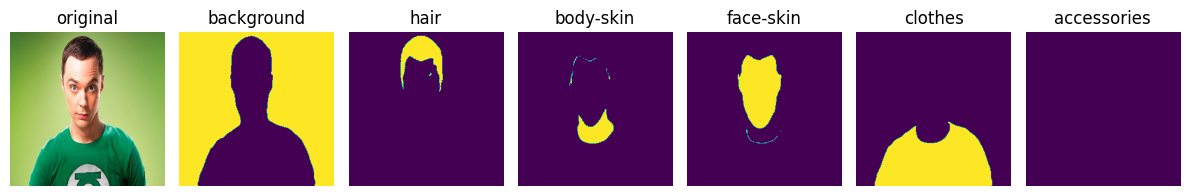

In [44]:
n = len(CLASSES)
fig, ax = plt.subplots(nrows=1, ncols=(n + 1), figsize=(12, 12))

ax[0].set_title('original')
ax[0].imshow(image[0, :, :, :])
ax[0].axis("off")

for i in range(n):
    sample = tvm_output[0, :, :, i]
    sample_label = CLASSES[i]

    ax[i + 1].set_title(sample_label)
    ax[i + 1].imshow(sample > 0.5)
    ax[i + 1].axis("off")

plt.tight_layout()
plt.show()